In [79]:
import pm4py
import io
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.bpmn import visualizer as bpmn_vis
from pm4py.statistics.traces.generic.log import case_statistics
from IPython.display import Markdown, display

In [80]:
import pm4py
log_domestic = pm4py.read_xes('Data/DomesticDeclarations.xes')
log_international = pm4py.read_xes('Data/InternationalDeclarations.xes')

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

In [81]:
endactivities_log_domestic = pm4py.get_end_activities(log_domestic)
print(f'Es gibt im Domestic-Datensatz {len(endactivities_log_domestic)} unterschiedliche Endaktivitäten.')
endactivities_log_domestic

unique_case_ids_domestic = log_domestic['case:id'].unique()
print(f'Es existieren insgesamt {len(unique_case_ids_domestic)} Traces im zugehörigen log_domestic.')

Es gibt im Domestic-Datensatz 6 unterschiedliche Endaktivitäten.
Es existieren insgesamt 10500 Traces im zugehörigen log_domestic.


In [82]:
from pm4py.statistics.end_activities.log import get as end_activities_get

end_activities_freq_domestic = end_activities_get.get_end_activities(log_domestic)

print('Die Endaktivitäten des Domestic-Logs und ihre absoluten Häufigkeiten sind nachfolgend aufgeführt:\n')

for activity, frequency in end_activities_freq_domestic.items():
    print(f"Activity: {activity}, Frequency: {frequency}")

Die Endaktivitäten des Domestic-Logs und ihre absoluten Häufigkeiten sind nachfolgend aufgeführt:

Activity: Payment Handled, Frequency: 10043
Activity: Declaration SAVED by EMPLOYEE, Frequency: 134
Activity: Declaration REJECTED by MISSING, Frequency: 30
Activity: Declaration REJECTED by EMPLOYEE, Frequency: 284
Activity: Declaration REJECTED by ADMINISTRATION, Frequency: 5
Activity: Declaration REJECTED by SUPERVISOR, Frequency: 4


In [83]:
import pm4py
from pm4py.algo.filtering.log.end_activities import end_activities_filter

# Einschränkung der Auswahl an Endereignissen aus dem log_domestic auf 'rejected-Fälle':
target_end_activities_domestic = [
    # Payment Handled
    #'Declaration SAVED by EMPLOYEE',
    'Declaration REJECTED by MISSING',
    'Declaration REJECTED by EMPLOYEE',
    'Declaration REJECTED by ADMINISTRATION',
    'Declaration REJECTED by SUPERVISOR'
]

# Filtere das Log basierend auf den Endereignissen
filtered_log_rejected_domestic = end_activities_filter.apply(log_domestic, target_end_activities_domestic)

# Überprüfe die Anzahl der verbleibenden Fälle
print(f'Anzahl der abgewiesenen Fälle bei inländischen Reiseanträgen beträgt: {len(filtered_log_rejected_domestic)} von insgesamt {len(unique_case_ids_domestic)}. '
      f'Das entspricht etwa '
      f'{len(filtered_log_rejected_domestic) / len(unique_case_ids_domestic):.2%}')


Anzahl der abgewiesenen Fälle bei inländischen Reiseanträgen beträgt: 323 von insgesamt 10500. Das entspricht etwa 3.08%


In [84]:
endactivities_log_international = pm4py.get_end_activities(log_international)
print(f'Es gibt im Interantional-Datensatz {len(endactivities_log_international)} unterschiedliche Endaktivitäten.')
endactivities_log_international

unique_case_ids_international = log_international['case:id'].unique()
print(f'Es existieren insgesamt {len(unique_case_ids_international)} Traces im log_domestic.')

Es gibt im Interantional-Datensatz 10 unterschiedliche Endaktivitäten.
Es existieren insgesamt 6449 Traces im log_domestic.


In [85]:
from pm4py.statistics.end_activities.log import get as end_activities_get

end_activities_freq_international = end_activities_get.get_end_activities(log_international)


print('Die Endaktivitäten des Domestic-Logs und ihre absoluten Häufigkeiten sind nachfolgend aufgeführt:\n')

for activity, frequency in end_activities_freq_international.items():
    print(f"Activity: {activity}, Frequency: {frequency}")

Die Endaktivitäten des Domestic-Logs und ihre absoluten Häufigkeiten sind nachfolgend aufgeführt:

Activity: Payment Handled, Frequency: 5646
Activity: End trip, Frequency: 593
Activity: Declaration SAVED by EMPLOYEE, Frequency: 54
Activity: Permit REJECTED by MISSING, Frequency: 8
Activity: Declaration REJECTED by MISSING, Frequency: 11
Activity: Declaration REJECTED by EMPLOYEE, Frequency: 130
Activity: Declaration FINAL_APPROVED by SUPERVISOR, Frequency: 1
Activity: Send Reminder, Frequency: 2
Activity: Request Payment, Frequency: 3
Activity: Declaration REJECTED by SUPERVISOR, Frequency: 1


In [86]:
print('Die Endaktivitäten des internationalen Datensätze werden nur auf die abgewiesenen Fälle eingeschränkt.')
target_end_activities_international = [
 # 'Payment Handled',
 # 'End trip',
 # 'Declaration SAVED by EMPLOYEE',
 'Permit REJECTED by MISSING',
 'Declaration REJECTED by MISSING',
 'Declaration REJECTED by EMPLOYEE',
 # 'Declaration FINAL_APPROVED by SUPERVISOR',
 # 'Send Reminder',
 # 'Request Payment',
 'Declaration REJECTED by SUPERVISOR'
]

Die Endaktivitäten des internationalen Datensätze werden nur auf die abgewiesenen Fälle eingeschränkt.


In [87]:
import pm4py
from pm4py.algo.filtering.log.end_activities import end_activities_filter

filtered_log_rejected_domestic = end_activities_filter.apply(log_domestic, target_end_activities_domestic)

filtered_log_rejected_international = end_activities_filter.apply(log_international, target_end_activities_international)

print(f'Anzahl der abgewiesenen Fälle bei internationalen Reiseanträgen beträgt: {len(filtered_log_rejected_international)} von insgesamt {len(unique_case_ids_international)}. '
      f'Das entspricht etwa '
      f'{len(filtered_log_rejected_international) / len(unique_case_ids_international):.2%}')

Anzahl der abgewiesenen Fälle bei internationalen Reiseanträgen beträgt: 150 von insgesamt 6449. Das entspricht etwa 2.33%


-----------

### Darstellung der Unterschiede

Um Unterschiede zwischen den beiden Logs gegliedert nach Endaktivitäten darzustellen, wird zunächst ein neues Dataframe 'df_combined' erzeugt. <br>
Für dieses Dataframe werden zunächst die durchschnittlichen Durchlaufzeiten  in Stunden sowie die zugehörigen Standardabweichungen dargestellt.

In [88]:
import pm4py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_data(log, log_type):
    end_activities = []
    case_durations = []
    for trace in log:
        end_activity = trace[-1]['concept:name']
        end_activities.append(end_activity)

        duration = ((trace[-1]['time:timestamp'] - trace[0]['time:timestamp']).total_seconds()/60/60)
        case_durations.append(duration)
    
    data = {'End Activity': end_activities, 'Duration': case_durations, 'Log Type': log_type}
    return pd.DataFrame(data)

df_domestic = prepare_data(filtered_log_rejected_domestic, 'Domestic')
df_international = prepare_data(filtered_log_rejected_international, 'International')

# Kombiniertes Dataframe erstellen
df_combined = pd.concat([df_domestic, df_international])


In [89]:
import pandas as pd
from IPython.display import Markdown, display

pivot_table = df_combined.pivot_table(
    index='End Activity',
    columns='Log Type',
    values='Duration',
    aggfunc=[ 'count', 'mean', 'std']
)

pivot_table_reset = pivot_table.reset_index()

pivot_table_reset.columns = [' '.join(col).strip() for col in pivot_table_reset.columns.values]

# Spaltennamen umbenennen
pivot_table_reset.rename(columns={
    'count Domestic': 'Anz. Inland',
    'count International': 'Anz. Ausland',
    'mean Domestic': 'Ø Inland (h)',
    'mean International':'Ø Ausland (h)',
    'std Domestic':'SD Inland (h)',
    'std International':'SD Ausland (h)'
}, inplace=True)

markdown_table = pivot_table_reset.to_markdown(index=False)

display(Markdown(markdown_table))


| End Activity                           |   Anz. Inland |   Anz. Ausland |   Ø Inland (h) |   Ø Ausland (h) |   SD Inland (h) |   SD Ausland (h) |
|:---------------------------------------|--------------:|---------------:|---------------:|----------------:|----------------:|-----------------:|
| Declaration REJECTED by ADMINISTRATION |             5 |            nan |       3834.96  |         nan     |        4344.56  |          nan     |
| Declaration REJECTED by EMPLOYEE       |           284 |            130 |        261.084 |        1734.76  |         738.262 |         1227.68  |
| Declaration REJECTED by MISSING        |            30 |             11 |        336.728 |        1675.3   |         654.374 |          995.321 |
| Declaration REJECTED by SUPERVISOR     |             4 |              1 |        156.207 |         599.161 |         188.919 |          nan     |
| Permit REJECTED by MISSING             |           nan |              8 |        nan     |        2451.41  |         nan     |          527.477 |

Die Daten aus der zuvor erzeugten Tabelle sollen nachfolgend für eine bessere Übersicht visualisiert werden. <br>
Die erste erzeugte Visualisierung beantworte die Frage nach der Anzahl der Abweisungen für inländische und ausländische Anträge und stellt die Summe der abgewiesenen Anträge in Abhängigkeit zu den Endaktivitäten dar. 

In [90]:
import seaborn as sns

sns.set_theme(
    palette="viridis",
    style="whitegrid"
)

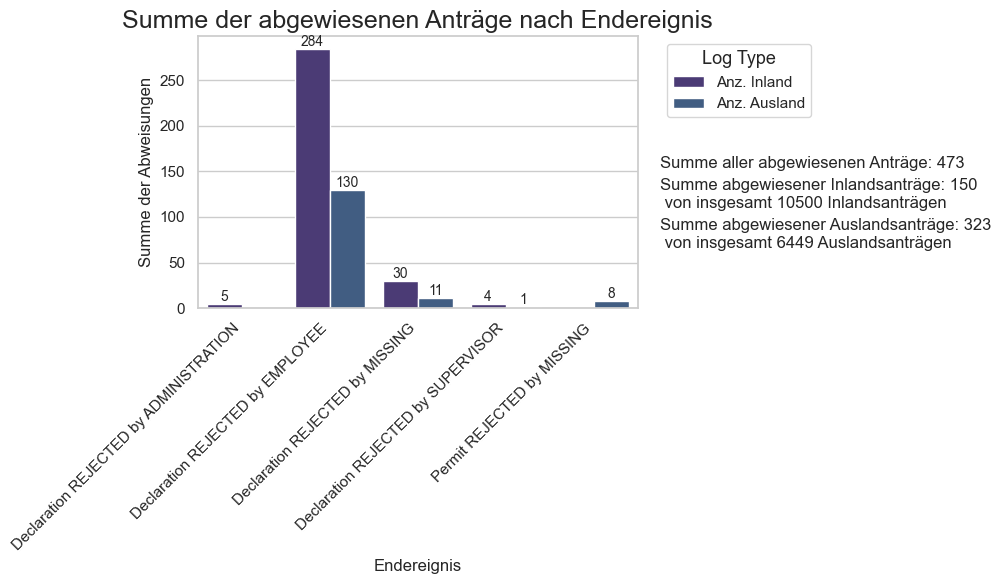

<Figure size 2000x1000 with 0 Axes>

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

count_columns = [col for col in pivot_table_reset.columns if 'Anz.' in col]

pivot_table_long = pivot_table_reset.melt(
    id_vars='End Activity',
    value_vars=count_columns,
    var_name='Log Type',
    value_name='Count'
    )

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=pivot_table_long, 
    x='End Activity', 
    y='Count', 
    hue='Log Type'
)

plt.title('Summe der abgewiesenen Anträge nach Endereignis', fontsize=18)
plt.xlabel('Endereignis')
plt.ylabel('Summe der Abweisungen')
plt.xticks(rotation=45, ha='right')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

total_count = int(pivot_table_long['Count'].sum())

sum_inlandsanträge = int(pivot_table_long[pivot_table_long['Log Type'].str.contains('Ausland')]['Count'].sum())
sum_auslandsanträge = int(pivot_table_long[pivot_table_long['Log Type'].str.contains('Inland')]['Count'].sum())

plt.legend(
    title='Log Type', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    title_fontsize='13', 
    fontsize='11'
)
# Text unter die Legende hinzufügen
plt.text(1.05, 0.5, f'Summe aller abgewiesenen Anträge: {total_count}\n', transform=ax.transAxes, fontsize=12, verticalalignment='center')
plt.text(1.05, 0.45, f'\nSumme abgewiesener Inlandsanträge: {sum_inlandsanträge}\n von insgesamt {len(unique_case_ids_domestic)} Inlandsanträgen', transform=ax.transAxes, fontsize=12, verticalalignment='center')
plt.text(1.05, 0.40, f'\n\n\n\nSumme abgewiesener Auslandsanträge: {sum_auslandsanträge}\n von insgesamt {len(unique_case_ids_international)} Auslandsanträgen', transform=ax.transAxes, fontsize=12, verticalalignment='center')

plt.tight_layout()

plt.savefig("./Data/sum_rejections.svg", format='svg', bbox_inches='tight')
plt.figure(figsize=(20, 10))

plt.show()

Die zuvor erstellte Tabelle wird nachfolgend visualisiert, um Ausreißer zu identifizieren und die Verteilungen zu vergleichen. Hierfür wird eine Kombination aus _Boxplot_ und _Swarmplot_ gewählt, Aufgrund des großen Datenbereichs für die Durchlaufzeiten in Stunden wurde für die y-Achse eine logarithmische Skalierung vorgenommen.

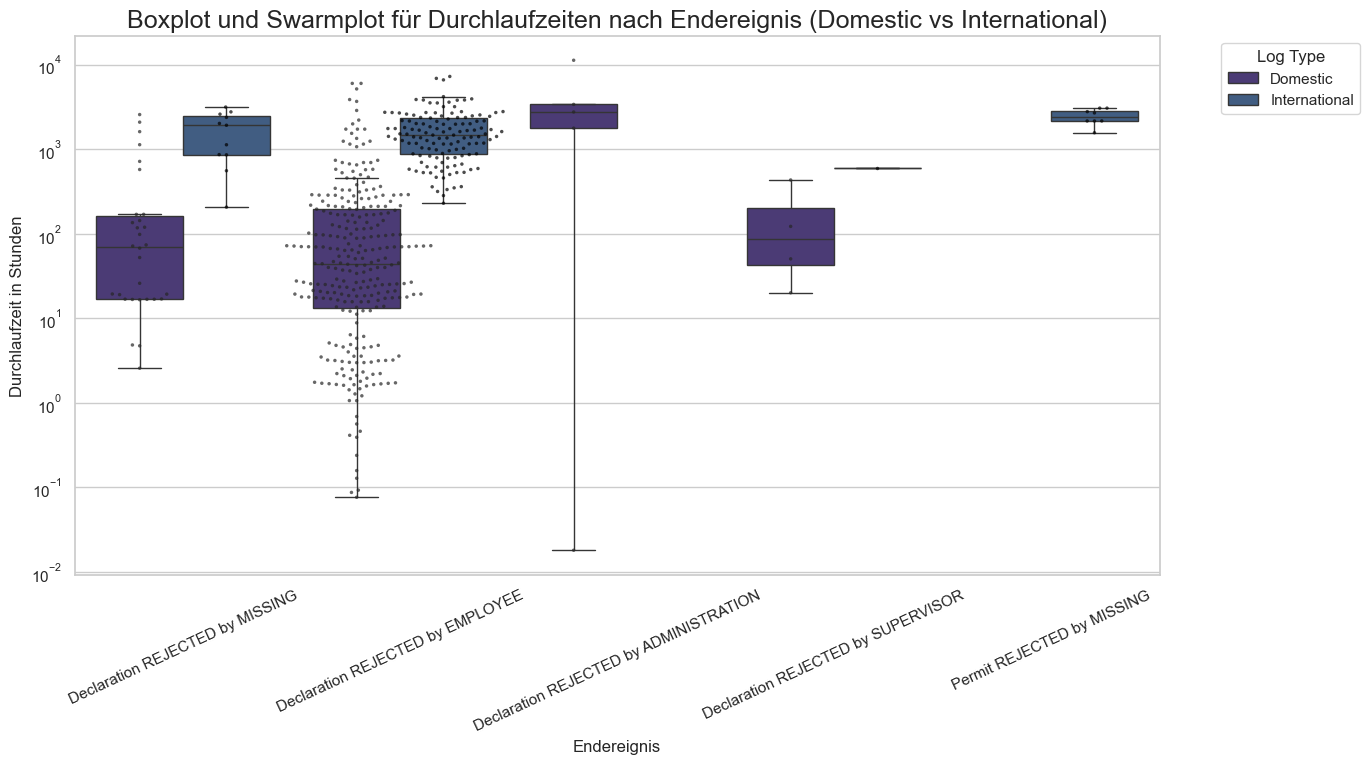

<Figure size 2000x1000 with 0 Axes>

- Die durchschnittlichen Durchlaufzeiten unterscheiden sich deutlich in Abhängigkeit zu ihren Enderergnissen
- Die häufigste Endaktivität ist in beiden untersuchten Logs ist _Declaration REJECTED by EMPLOYEE
- Es gibt in Bezug auf die Durchlaufzeiten der Traces deutliche Ausreißer und Schwankungen, insbesondere bei Traces mit der Endaktivität "Declaration REJECTED by EMPLOYEE".


In [92]:
import matplotlib.pyplot as plt
import warnings
# Warnungen unterdrücken, um den Output übersichtlich zu halten:
warnings.filterwarnings("ignore") #, category=FutureWarning)

plt.figure(figsize=(14, 7))
sns.boxplot(
    x='End Activity', 
    y='Duration', 
    hue='Log Type', 
    data=df_combined, 
    showfliers=False
    )

sns.swarmplot(
    x='End Activity', 
    y='Duration', 
    hue='Log Type', 
    data=df_combined, 
    dodge=True, 
    marker='.', 
    alpha=0.7, 
    color='black'
    )

# Logarithmische Skalierung für die y-Achse
plt.yscale('log')

plt.title('Boxplot und Swarmplot für Durchlaufzeiten nach Endereignis (Domestic vs International)', fontsize=18)
plt.xlabel('Endereignis')
plt.ylabel('Durchlaufzeit in Stunden')
plt.xticks(rotation=25)

# Warnungen unterdrücken, um den Output übersichtlich zu halten:
warnings.filterwarnings("ignore", category=FutureWarning)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[:2], 
    labels[:2], 
    title='Log Type', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
    )

plt.savefig("./Data/box_swarmplot_troughputtimes_endevent.svg", format='svg', bbox_inches='tight')
plt.figure(figsize=(20, 10))

plt.show()

print(f'- Die durchschnittlichen Durchlaufzeiten unterscheiden sich deutlich in Abhängigkeit zu ihren Enderergnissen\n'
      '- Die häufigste Endaktivität ist in beiden untersuchten Logs ist _Declaration REJECTED by EMPLOYEE\n'
      '- Es gibt in Bezug auf die Durchlaufzeiten der Traces deutliche Ausreißer und Schwankungen, insbesondere bei Traces mit der Endaktivität "Declaration REJECTED by EMPLOYEE".'
      )

[Kehre zurück zum Hauptnotebook](../0_Hauptnotebook.ipynb)